# Nuclear Instance Segmentation and Classification

## EDA

The dataset contains image regions extracted from colon whole-slide images at 20x objective magnification along with their corresponding labels. Each label provides:

- Instance segmentation map
- Category of each nucleus
- Bounding box of each nucleus
- Centroid of each nucleus

The nuclear categories provided as part of this dataset are:

- Class 1: Neutrophil
- Class 2: Epithelial
- Class 3: Lymphocyte
- Class 4: Plasma
- Class 5: Neutrophil
- Class 6: Connective tissue

Each label is stored as a mat file. We provide some sample code (read_label.py) to provide information on how to read the labels. It should be noted that models trained on data at 40x may need to be adapted appropriately.

Detailed descriptipon about the dataset:
Graham, Simon, et al. "Lizard: A Large-Scale Dataset for Colonic Nuclear Instance Segmentation and Classification." Proceedings of the IEEE/CVF International Conference on Computer Vision. 2021.


In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [2]:
pic = "consep_1" # input("Enter the picture name:")

In [3]:
label = sio.loadmat(f'lizard_labels/Lizard_Labels/Labels/{pic}.mat')

# Load the instance segmentation map.
# This map is of type int32 and contains values from 0 to N, where 0 is background
# and N is the number of nuclei. 
# Shape: (H, W) where H and W is the height and width of the image.
inst_map = label['inst_map']
print(inst_map.shape)


# Load the index array. This determines the mapping between the nuclei in the instance map and the
# corresponing provided categories, bounding boxes and centroids.
nuclei_id = label['id'] # shape (N, 1), where N is the number of nuclei.

# Load the nuclear categories / classes. 
# Shape: (N, 1), where N is the number of nuclei.
classes = label['class']

# Load the bounding boxes.
# Shape: (N, 4), where N is the number of nuclei.
# For each row in the array, the ordering of coordinates is (y1, y2, x1, x2). 
bboxs = label['bbox'] 

# Load the centroids.
# Shape: (N, 2), where N is the number of nuclei.
# For each row in the array, the ordering of coordinates is (x, y).
centroids = label['centroid'] 

# Matching each nucleus with its corresponding class, bbox and centroid:

# Get the unique values in the instance map - each value corresponds to a single nucleus.
unique_values = np.unique(inst_map).tolist()[1:] # remove 0

# print(inst_map, nuclei_id, classes, bboxs, centroids, unique_values)

# Convert nuclei_id to list.
nuclei_id = np.squeeze(nuclei_id).tolist()

# Initialize lists to store data
indices = []
class_list = []
bbox_list = []
centroid_list = []

for value in unique_values:
    idx = nuclei_id.index(value)  # Get the index
    indices.append(idx)
    class_list.append(classes[idx].item())  # Convert to Python int
    bbox_list.append(bboxs[idx].tolist())
    centroid_list.append(centroids[idx].tolist())

# Create a DataFrame
data = {'Index': indices, 'Class': class_list, 'Bounding Box': bbox_list, 'Centroid': centroid_list}
df = pd.DataFrame(data)

# Display the DataFrame
print(print(df.to_string(index=False)))

(500, 500)
 Index  Class         Bounding Box                                 Centroid
     0      2    [1, 24, 138, 161]  [148.8421052631579, 13.233082706766917]
     1      2   [420, 442, 47, 66]   [55.63548387096774, 431.0774193548387]
     2      2 [138, 160, 182, 204]  [192.2902097902098, 150.77272727272728]
     3      2 [146, 168, 138, 157] [147.55272727272728, 157.16727272727272]
     4      2   [408, 423, 73, 96]    [84.37246963562752, 415.497975708502]
     5      2 [311, 333, 399, 416]  [407.42914979757086, 322.7894736842105]
     6      2 [114, 140, 430, 444] [437.38955823293173, 126.21686746987952]
     7      2 [316, 330, 192, 216]  [203.4356846473029, 322.18672199170123]
     8      2 [311, 335, 380, 393]  [385.8181818181818, 322.05371900826447]
     9      2   [75, 93, 151, 173]   [161.05982905982907, 83.7051282051282]
    10      2  [93, 121, 427, 443] [433.95217391304345, 105.50434782608696]
    11      2   [43, 60, 446, 465]  [455.23478260869564, 51.41304347826087]
 

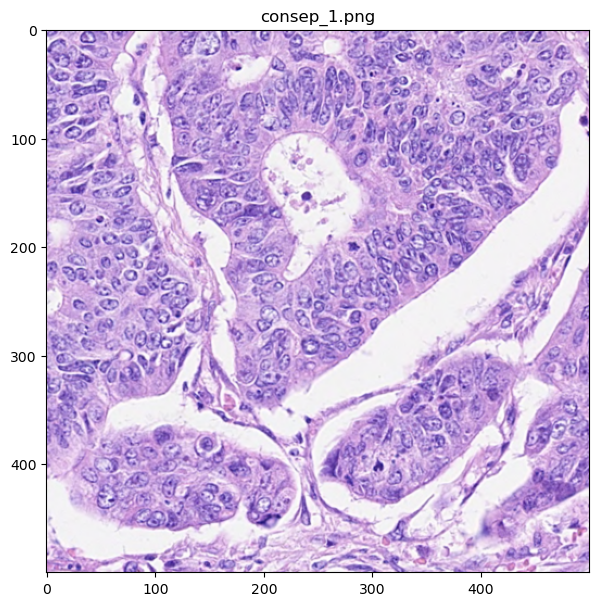

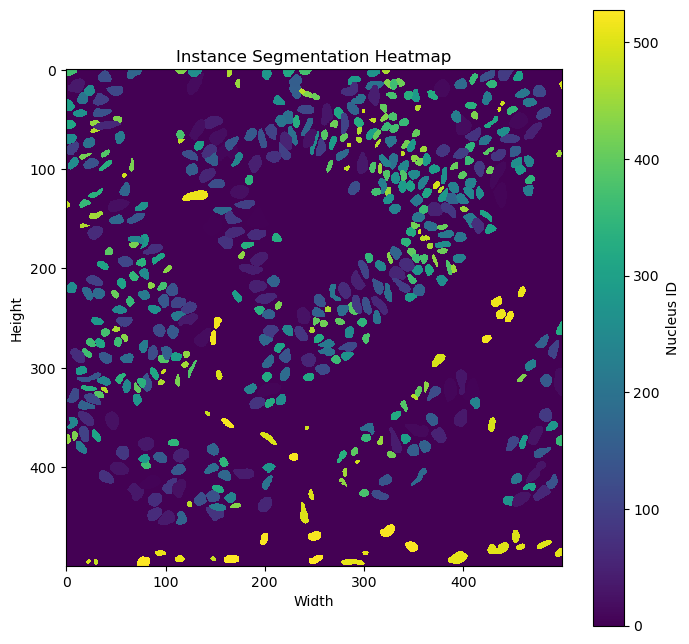

In [4]:
# Load the image
image_path = f'lizard_images1/Lizard_Images1/{pic}.png'
image = Image.open(image_path)

# Plot the image
plt.figure(figsize=(7, 8))
plt.imshow(image)
plt.title(f'{pic}.png')  
plt.axis('on')
plt.show()

# Plot the heatmap
plt.figure(figsize=(8, 8))
plt.imshow(inst_map, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Nucleus ID')
plt.title('Instance Segmentation Heatmap')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

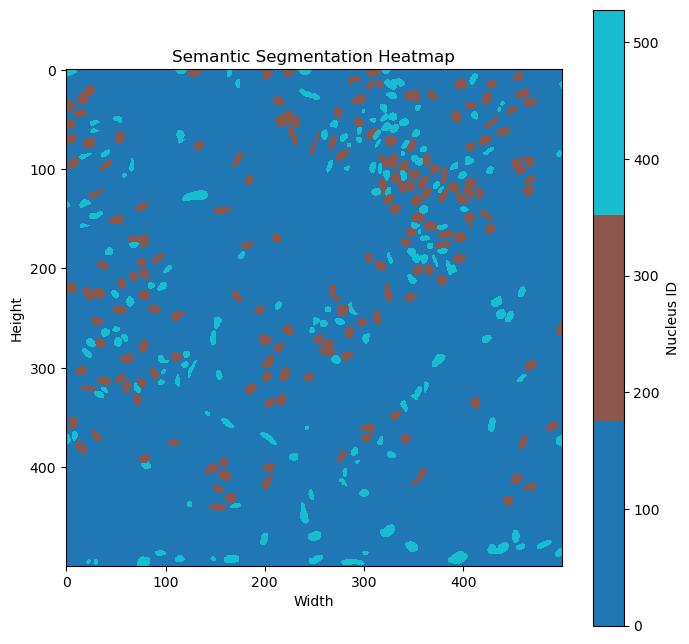

In [5]:
# Define the number of unique classes
num_classes = len(df['Class'].unique())

# Create a colormap with a different color for each class
cmap = plt.cm.get_cmap('tab10', num_classes)

# Plot the heatmap
plt.figure(figsize=(8, 8))
plt.imshow(inst_map, cmap=cmap, interpolation='nearest')
plt.colorbar(label='Nucleus ID')
plt.title('Semantic Segmentation Heatmap')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

# # Initialize a set to keep track of printed classes
# printed_classes = set()

# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(8, 4))

# # Add class numbers and names to the plot
# for class_id, color in zip(range(1, num_classes + 1), cmap.colors):
#     # Check if the class has already been printed
#     if class_id not in printed_classes:
#         # Plot a bar with the class number
#         ax.bar(class_id, 1, color=color, label=f'Class {class_id}')
#         # Add the class to the set of printed classes
#         printed_classes.add(class_id)

# # Set labels and legend
# ax.set_xlabel('Class')
# ax.set_ylabel('Color')
# ax.set_title('Unique Classes and Colors')
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# # Remove x-axis ticks
# ax.set_xticks([])

plt.show()

## Data preprocessing 

### Creating array of images

In [6]:
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path)
                images.append(img)
            except Exception as e:
                print(f"Error loading image '{img_path}': {e}")
    return images

def images_to_array(images, target_size=(500, 500)):
    num_images = len(images)
    if num_images == 0:
        return None

    array_shape = (num_images, *target_size, 3)  # Assuming RGB images
    image_array = np.zeros(array_shape, dtype=np.uint8)

    for i, img in enumerate(images):
        img = img.resize(target_size)  # Resize image
        image_array[i] = np.array(img)

    return image_array

folder_path = 'images_all'
images = load_images_from_folder(folder_path)
X = images_to_array(images)

# Save X to a file
np.save('images_array.npy', X)

# Delete X to free up memory
del X

### Creating array of labels

In [7]:
def load_index_class_pairs(pic):
    label = sio.loadmat(f'lizard_labels/Lizard_Labels/Labels/{pic}.mat')

    # Load the index array.
    nuclei_id = label['id'].squeeze().tolist()  # Convert to list

    # Load the nuclear categories / classes.
    classes = label['class'].squeeze().tolist()  # Convert to list

    # Combine index and class into a dictionary
    index_class_dict = {index: class_ for index, class_ in zip(nuclei_id, classes)}

    return index_class_dict

def replace_indices_with_classes(inst_map, index_class_dict):
    # Replace indices with classes in the instance map
    inst_map_replaced = np.zeros_like(inst_map)
    for index, class_ in index_class_dict.items():
        inst_map_replaced[inst_map == index] = class_

    return inst_map_replaced


if os.path.exists('inst_maps_replaced.npy'):
    # If the file exists, load it
    all_inst_maps_replaced = np.load('inst_maps_replaced.npy', allow_pickle=True)
    print("Replaced instance maps loaded from 'inst_maps_replaced.npy'")
else:
    # If the file does not exist, process the .mat files
    # Get list of .mat files
    mat_files = [file for file in os.listdir('lizard_labels/Lizard_Labels/Labels/') if file.endswith('.mat')]

    # Sort .mat files to maintain order
    mat_files.sort()

    # Initialize list to store replaced instance maps for all images
    all_inst_maps_replaced = []

    # Loop through .mat files
    for file in mat_files:
        # Load index-class pairs for the current file
        index_class_dict = load_index_class_pairs(file[:-4])  # Remove extension (.mat) from file name

        # Load the instance segmentation map
        label = sio.loadmat(f'lizard_labels/Lizard_Labels/Labels/{file}')

        # Get the instance map
        inst_map = label['inst_map']

        # Replace indices with classes
        inst_map_replaced = replace_indices_with_classes(inst_map, index_class_dict)

        all_inst_maps_replaced.append(inst_map_replaced)
        print(f"{file} appended.")

    # Convert list to numpy array
    all_inst_maps_replaced = np.array(all_inst_maps_replaced)

    # Save the array to a file
    np.save('inst_maps_replaced.npy', all_inst_maps_replaced)
    print("Replaced instance maps saved to 'inst_maps_replaced.npy'")


Replaced instance maps loaded from 'inst_maps_replaced.npy'


## Augmentation

In [8]:
# # Display original image and label
# original_image = X_train[0]
# original_label = y_train[0]

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(original_image, cmap='gray')
# axes[0].set_title('Original Image')
# axes[1].imshow(original_label, cmap='viridis')
# axes[1].set_title('Original Label')
# plt.show()

# # Data Augmentation
# datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
#                              shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)

# # Fit the augmentation parameters on the training data
# datagen.fit(X_train.reshape(-1, *X_train.shape[1:]))

# # Apply augmentation to images and labels
# augmented_images = []
# augmented_labels = []

# for X_batch, y_batch in datagen.flow(X_train.reshape(-1, *X_train.shape[1:]), y_train.reshape(-1, *y_train.shape[1:]), batch_size=len(X_train)):
#     augmented_images.append(X_batch.reshape(X_train.shape))
#     augmented_labels.append(y_batch.reshape(y_train.shape))
#     break

# # Display augmented image and label
# augmented_image = augmented_images[0][0]
# augmented_label = augmented_labels[0][0]

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(augmented_image, cmap='gray')
# axes[0].set_title('Augmented Image')
# axes[1].imshow(augmented_label, cmap='viridis')
# axes[1].set_title('Augmented Label')
# plt.show()

# # Normalization
# normalized_images = []
# for image in augmented_images[0]:
#     normalized_image = exposure.rescale_intensity(image, in_range=(np.min(image), np.max(image)))
#     normalized_images.append(normalized_image)

# # Display normalized image
# normalized_image = normalized_images[0]
# plt.imshow(normalized_image, cmap='gray')
# plt.title('Normalized Image')
# plt.show()

# # Resizing
# resized_images = []
# resized_labels = []
# target_size = (256, 256)  # Define target size for resizing

# for image, label in zip(normalized_images, augmented_labels[0]):
#     resized_image = resize(image, target_size, anti_aliasing=True)
#     resized_label = resize(label, target_size, anti_aliasing=False, order=0)  # Use nearest neighbor interpolation for labels
#     resized_images.append(resized_image)
#     resized_labels.append(resized_label)

# # Display resized image and label
# resized_image = resized_images[0]
# resized_label = resized_labels[0]

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(resized_image, cmap='gray')
# axes[0].set_title('Resized Image')
# axes[1].imshow(resized_label, cmap='viridis')
# axes[1].set_title('Resized Label')
# plt.show()